In [213]:
from pkg.utils import rle_to_mask

In [214]:
from pathlib import Path
dataroot = Path('/home/nhtlong/data/public')
imgroot = dataroot / 'img' / 'valid'
annroot = dataroot / 'ann' / 'valid'

In [215]:
import json 
import rich
with open('valid.json', 'r') as f:
    valid = json.load(f)
    
# get random key
import random
key = random.choice(list(valid.keys()))
print(valid[key].keys())
print(valid[key]['width'], valid[key]['height'])

dict_keys(['counts', 'height', 'width'])
439 384


In [216]:
rle = valid[key]['counts']
width = valid[key]['width']
height = valid[key]['height']
pred = rle_to_mask(rle, (width, height))
print(pred.shape)

(384, 439)


In [217]:
def overlap(pred, gt):
    return (pred * gt).sum() / gt.sum()
def acc(pred, gt):
    return (pred == gt).sum() / gt.size

(384, 439, 3)


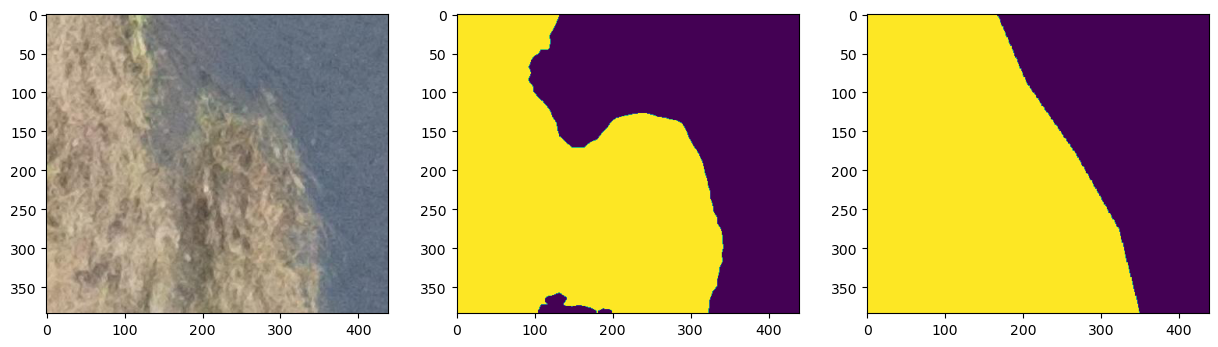

0.8489338106541111

In [218]:
# display overlay, compare with annotation
from PIL import Image
import numpy as np

img = Image.open(imgroot / key)
img = img.convert('RGB')
img = np.array(img)
print(img.shape)

ann = Image.open(annroot / key.replace('.jpg', '.png'))
ann = np.array(ann)

from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[1].imshow(pred)
ax[2].imshow(ann)
plt.show()
overlap(pred, ann)


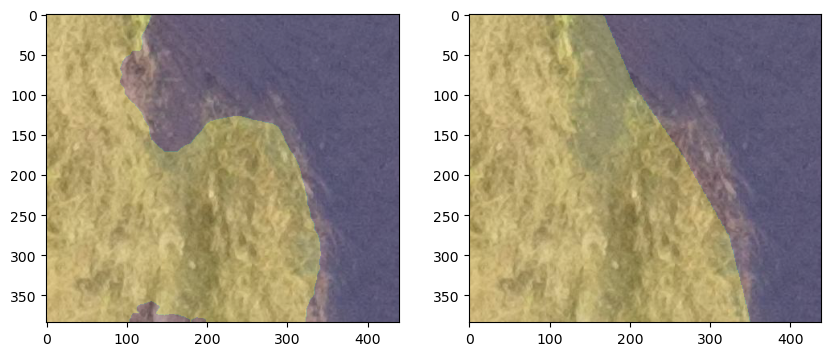

In [219]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[0].imshow(pred, alpha=0.2)

ax[1].imshow(img)
ax[1].imshow(ann, alpha=0.2)
plt.show()


In [220]:
import cv2


def findContours(*args, **kwargs):
    """
    Wraps cv2.findContours to maintain compatiblity between versions
    3 and 4

    Returns:
        contours, hierarchy
    """
    if cv2.__version__.startswith('4'):
        contours, hierarchy = cv2.findContours(*args, **kwargs)
    elif cv2.__version__.startswith('3'):
        _, contours, hierarchy = cv2.findContours(*args, **kwargs)
    else:
        raise AssertionError(
            'cv2 must be either version 3 or 4 to call this method')

    return contours, hierarchy

In [221]:
def mask2poly(mask):
    contour, hier = findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    polygons = [c.reshape(-1).tolist() for c in contour]
    return polygons

def smooth(polygons, smooth=1, max_area=1e5):
    polygons = [p for p in polygons if len(p) >= 6]
    polygons = [p if p[-2:] != p[:2] else p[:-1] for p in polygons]
    polygons = [cv2.approxPolyDP(np.array(p).reshape(-1, 2), smooth, True).reshape(-1).tolist() for p in polygons]
    polygons = [p for p in polygons if len(p) >= 6]
    polygons = [p if p[-2:] != p[:2] else p[:-1] for p in polygons]
    polygons = [p for p in polygons if cv2.contourArea(np.array(p).reshape(-1, 2)) < max_area]
    return polygons

def poly2mask(polygons, width, height):
    mask = np.zeros((height, width), dtype=np.uint8)
    polygons = [np.asarray(p).reshape(-1, 2).astype(int) for p in polygons]
    cv2.fillPoly(mask, polygons, 1)
    return mask

def eroding(mask, kernel_size=5):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=1)
    return mask

In [222]:
polygons = mask2poly(eroding(pred))
polygons = smooth(polygons, smooth=5, max_area=1e5)
pred_poly = poly2mask(polygons, width, height)
pred_poly = eroding(pred_poly, kernel_size=5)

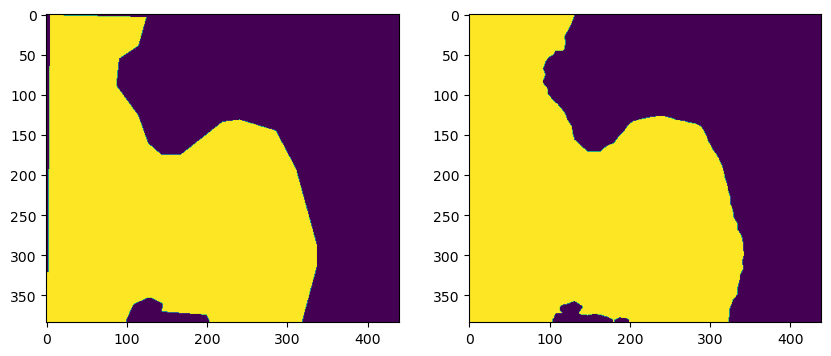

0.8586572228549735
0.8748813591495824


In [223]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(pred_poly)
ax[1].imshow(pred)
plt.show()
print(acc(pred_poly, ann))
print(acc(pred, ann))